## Import Library

In [44]:
import os
import json
import warnings
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, f1_score, precision_recall_curve, average_precision_score,
    recall_score,
)
import joblib
from catboost import CatBoostClassifier
from IPython.display import display

warnings.filterwarnings('ignore', category=UserWarning)

project_path = "E:/Project/HepatitisC-Prediction/"
file_path = f"{project_path}/Dataset/cleaned_dataset.csv"
result_path = f"{project_path}/Result"
hyper_path = f"{result_path}/Hyperparameter"
model_path = f"{project_path}/Models"

## Load Dataset

In [45]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())

(3687, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3687 non-null   int64  
 1   gender               3687 non-null   int64  
 2   jaundice_history     3687 non-null   int64  
 3   receive_transfusion  3687 non-null   int64  
 4   liver_condition      3687 non-null   int64  
 5   injectable_drug_use  3687 non-null   int64  
 6   drug_use             3687 non-null   int64  
 7   alcohol_consumption  3687 non-null   int64  
 8   alt                  3687 non-null   float64
 9   albumin              3687 non-null   float64
 10  alp                  3687 non-null   float64
 11  ast                  3687 non-null   float64
 12  bun                  3687 non-null   float64
 13  cholesterol          3687 non-null   float64
 14  cpk                  3687 non-null   float64
 15  creatinine           3687 n

In [46]:
df_train = df[df['dataset'] == 'train']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['hcv_status', 'dataset'])
y_train = df_train['hcv_status']

X_test = df_test.drop(columns=['hcv_status', 'dataset'])
y_test = df_test['hcv_status']

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3198, 26)
Test shape: (489, 26)


In [48]:
numeric_features_to_scale = ['age', 'alt', 'albumin', 'alp', 'ast', 'bun', 'cholesterol', 'cpk', 'creatinine', 'ggt', 'glucose', 'total_bilirubin', 'total_calcium', 'total_protein', 'triglycerides', 'uric_acid', 'ldh', 'globulin', 'osmolality']
categorical_features = ['gender', 'education_level', 'receive_transfusion', 'liver_condition', 'injectable_drug_use', 'drug_use', 'alcohol_consumption']

# Buat preprocessor (akan di-fit dalam Pipeline)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_to_scale)
    ],
    remainder='passthrough'
)

catboost_base = CatBoostClassifier(
    random_state=42,
    silent=True,
    allow_writing_files=False,
    early_stopping_rounds=20  # Stop jika tidak ada improvement
)

# Buat Pipeline: Preprocessor -> Model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', catboost_base)
])

print("Pipeline created")

Pipeline created


## Hyperparameter Tuning (5-Fold CV)

In [ ]:
param_grid = {
    'classifier__iterations': [100, 150, 200],  
    'classifier__learning_rate': [0.03, 0.05, 0.08],  
    'classifier__depth': [4, 5, 6],  
    'classifier__l2_leaf_reg': [3, 5, 7], 
    'classifier__min_data_in_leaf': [5, 10, 20] 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Parameter Grid (Conservative):")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
    
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal kombinasi parameter: {total_combinations}")
print(f"Total fits yang akan dilakukan: {total_combinations * 5} (5-fold CV)")

Parameter Grid (Conservative):
  classifier__iterations: [100, 150, 200]
  classifier__learning_rate: [0.03, 0.05, 0.08]
  classifier__depth: [4, 5, 6]
  classifier__l2_leaf_reg: [3, 5, 7]
  classifier__min_data_in_leaf: [5, 10, 20]

Total kombinasi parameter: 243
Total fits yang akan dilakukan: 1215 (5-fold CV)


In [ ]:
print("Memulai GridSearchCV untuk CatBoost dengan Pipeline...")
print("=" * 60)

grid_search = GridSearchCV(
    estimator=pipeline,  
    param_grid=param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("\n" + "=" * 60)
print("GridSearchCV Selesai!")
print("=" * 60)

Memulai GridSearchCV untuk CatBoost dengan Pipeline...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

GridSearchCV Selesai!

GridSearchCV Selesai!


## Hasil GridSearchCV

In [51]:
print("=" * 60)
print("HASIL HYPERPARAMETER TUNING")
print("=" * 60)

print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    clean_param = param.replace('classifier__', '')
    print(f"  {clean_param}: {value}")

print(f"\nBest Cross-Validation Recall Score: {grid_search.best_score_:.4f}")

os.makedirs(hyper_path, exist_ok=True)

best_params_clean = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}
best_params_clean['best_cv_score'] = grid_search.best_score_

with open(f"{hyper_path}/catboost_best_params.json", 'w') as f:
    json.dump(best_params_clean, f, indent=4)

HASIL HYPERPARAMETER TUNING

Best Parameters:
  depth: 6
  iterations: 200
  l2_leaf_reg: 7
  learning_rate: 0.08
  min_data_in_leaf: 5

Best Cross-Validation Recall Score: 0.9787


In [56]:
# Analisis CV scores per fold
cv_results = grid_search.cv_results_
best_idx = grid_search.best_index_

print("\n" + "=" * 60)
print("ANALISIS CV SCORES PER FOLD (Best Model)")
print("=" * 60)
fold_scores = []
for i in range(5):
    fold_score = cv_results[f'split{i}_test_score'][best_idx]
    fold_scores.append(fold_score)
    print(f"Fold {i+1}: {fold_score:.4f}")

print(f"\nCV Mean:  {np.mean(fold_scores):.4f}")



ANALISIS CV SCORES PER FOLD (Best Model)
Fold 1: 0.9688
Fold 2: 0.9844
Fold 3: 0.9844
Fold 4: 0.9749
Fold 5: 0.9812

CV Mean:  0.9787


## Evaluasi Model (Test Set)

In [66]:
best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

In [71]:
print("=" * 60)
print("EVALUASI MODEL PADA TEST SET (TUNED)")
print("=" * 60)
print(f"\nAccuracy:          {accuracy:.4f}")
print(f"Recall:            {recall_val:.4f}")
print(f"F1 Score:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

with open(f"{result_path}/CatBoost/CatBoost_evaluation.json", 'r') as f:
    default_json = json.load(f)

comparison_data = {
    'Metric': ['Accuracy', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision'],
    'Default': [
        default_json['accuracy'],
        default_json['recall'],
        default_json['f1_score'],
        default_json['roc_auc'],
        default_json['average_precision']
    ],
    'Tuned': [accuracy, recall_val, f1, roc_auc, avg_precision]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Tuned'] - comparison_df['Default']

def get_winner(diff):
    if diff > 0.0001:
        return 'Tuned'
    elif diff < -0.0001:
        return 'Default'
    else:
        return 'Tie'

comparison_df['Winner'] = comparison_df['Difference'].apply(get_winner)

comparison_display = comparison_df.copy()
comparison_display['Default'] = comparison_display['Default'].apply(lambda x: f"{x:.4f}")
comparison_display['Tuned'] = comparison_display['Tuned'].apply(lambda x: f"{x:.4f}")
comparison_display['Difference'] = comparison_display['Difference'].apply(lambda x: f"{x:+.4f}")

print("\n" + "=" * 60)
print("PERBANDINGAN: TUNED vs DEFAULT")
print("=" * 60)
display(comparison_display.style.hide(axis='index'))



EVALUASI MODEL PADA TEST SET (TUNED)

Accuracy:          0.9550
Recall:            0.9091
F1 Score:          0.8791
ROC AUC:           0.9920
Average Precision: 0.9687

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97       401
    Positive       0.85      0.91      0.88        88

    accuracy                           0.96       489
   macro avg       0.92      0.94      0.93       489
weighted avg       0.96      0.96      0.96       489


PERBANDINGAN: TUNED vs DEFAULT


Metric,Default,Tuned,Difference,Winner
Accuracy,0.9571,0.9550,-0.0020,Default
Recall,0.9091,0.9091,+0.0000,Tie
F1 Score,0.8840,0.8791,-0.0049,Default
ROC AUC,0.9931,0.9920,-0.0011,Default
Avg Precision,0.9723,0.9687,-0.0035,Default


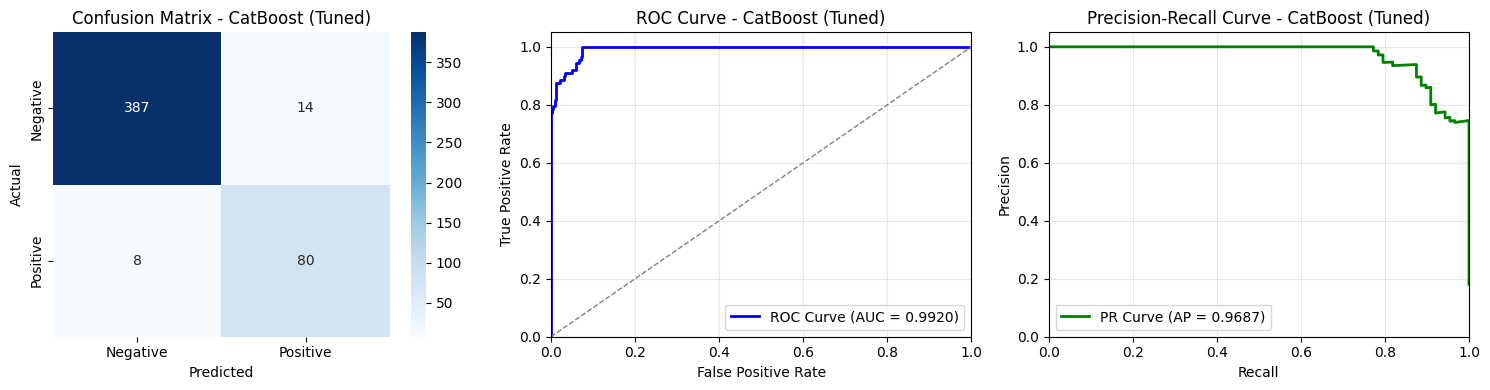

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_title('Confusion Matrix - CatBoost (Tuned)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - CatBoost (Tuned)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve - CatBoost (Tuned)')
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Simpan Model Terbaik

In [61]:
os.makedirs(model_path, exist_ok=True)

joblib.dump(best_pipeline, f"{model_path}/catboost_pipeline.joblib")

fitted_preprocessor = best_pipeline.named_steps['preprocessor']
joblib.dump(fitted_preprocessor, f"{model_path}/scaler.joblib")

cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=cv, scoring='recall')

evaluation_results = {
    'best_params': best_params_clean,
    'cv_score': float(grid_search.best_score_),
    'test_metrics': {
        'accuracy': float(accuracy),
        'recall': float(recall_val),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'average_precision': float(avg_precision)
    },
    'cv_scores_per_fold': [float(x) for x in cv_scores],
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std()),
    'note': 'Pipeline-based CV (no data leakage)'
}

os.makedirs(f"{result_path}/CatBoost_Tuned", exist_ok=True)
with open(f"{result_path}/CatBoost_Tuned/CatBoost_tuned_evaluation.json", 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("=" * 60)
print("MODEL DAN HASIL BERHASIL DISIMPAN")
print("=" * 60)

MODEL DAN HASIL BERHASIL DISIMPAN
